## Hyperspectral Image Segmentation by Convolutional Neural Network 

### standardized spectra at full resolution with spatial dimension included

### training on each image separately

---

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
def kmeans_test_dictionary(labels, test, k):
    import collections, numpy
    
    unique_test, counts_test = numpy.unique(labels[test[:,0], test[:,1]], return_counts=True)
    counts_test_norm = (counts_test/test.shape[0])*100
    test_dict = dict(zip(unique_test, counts_test))
    test_dict_norm = dict(zip(unique_test, counts_test_norm))
    
    for i in range(0, k):
        if test_dict.get(i) is None: test_dict[i] = 0
        if test_dict_norm.get(i) is None: test_dict_norm[i] = 0
    
    return test_dict, test_dict_norm

In [3]:
def kmeans_test_dataframe(sky_dict,
                          clouds_dict,
                          veg_dict,
                          wtr_dict,
                          blt_dict,
                          windows_dict,
                          rds_dict,
                          cars_dict,
                          mtl_dict
                         ):
    import pandas as pd
    
    pixel_names = ['sky', 'clouds', 'vegetation', 'water', 'built',
                  'windows', 'roads', 'cars', 'metal']
    df_test = pd.DataFrame([sky_dict,
                            clouds_dict,
                            veg_dict,
                            wtr_dict,
                            blt_dict,
                            windows_dict,
                            rds_dict,
                            cars_dict,
                            mtl_dict], index=pixel_names)
    df_test = df_test.transpose()
    
    return df_test

In [4]:
def plot_confusion_matrix(df_test, norm=True):
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    cm = np.array([df_test['sky'].values,
                   df_test['clouds'].values,
                   df_test['vegetation'].values,
                   df_test['water'].values,
                   df_test['built'].values,
                   df_test['windows'].values,
                   df_test['roads'].values,
                   df_test['cars'].values,
                   df_test['metal'].values])
    classes = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 
              'cars', 'metal']
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    if norm:
        title='Normalized Confusion Matrix'
        fmt='.2f'
    else:
        title='Confusion Matrix'
        fmt='d'
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=np.arange(0,cm.shape[1]).astype(str), 
          yticklabels=classes,
          title=title,
          ylabel='True Label',
          xlabel='Predicted Label')
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #        rotation_mode="anchor")
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i,j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [5]:
def plot_test_result(df_Test):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    df_test = df_Test.transpose()
    ax = df_test.plot.bar(rot=0, stacked=True, colormap='tab20b')
                          #color=['tab:blue', 'tab:green', 'tab:gray'])
    plt.xlabel('Actual Class')
    plt.ylabel('%of Test Pixels')
    plt.title('Error in Prediction')
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':11})
    plt.show()

In [6]:
def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [7]:
def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)

In [8]:
def read_labelled_coordinates(kind, scan):
    file = open("../manual_classified_pixels/{0}_coordinates_{1}.txt".format(kind, scan), "r")
    coords = file.readlines()
    file.close()
    coords = np.array([point_from_string(line) for line in coords])
    print("{0}: {1}".format(kind,coords.shape))
    
    return coords

In [9]:
import random

def split_train_test_indices(coords, seed, trrat, kind):
    ind = np.arange(coords.shape[0])
    random.Random(seed).shuffle(ind)
    lim_ind = int(len(ind)*trrat)
    train_ind = ind[:lim_ind]
    test_ind = ind[lim_ind:]
    
    print("{0}: {1} {2}".format(kind, len(train_ind), len(test_ind)))
    
    return train_ind, test_ind

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def CNN_Model(nwaves, filtersize):
    Inputs_1 = keras.Input(shape=(nwaves, 1), name="spectra")
    Conv1D_1 = layers.Conv1D(16, kernel_size=(filtersize), padding="same", activation="relu")(Inputs_1)
    MaxPool_1 = layers.MaxPooling1D((2), strides=2)(Conv1D_1)
    Conv1D_2 = layers.Conv1D(32, kernel_size=(filtersize), padding="same", activation="relu")(MaxPool_1)
    MaxPool_2 = layers.MaxPooling1D((2), strides=2)(Conv1D_2)
    Dropout_1 = layers.Dropout(0.5)(MaxPool_2)
    Flatten_1 = layers.Flatten()(Dropout_1)

    Inputs_2 = keras.Input(shape=(2,), name="spatial")
    Concat = layers.concatenate([Flatten_1, Inputs_2])
    Dense_1 = layers.Dense(512, activation="relu")(Concat)
    Output = layers.Dense(9, activation="softmax")(Dense_1)

    model = keras.Model(inputs=[Inputs_1, Inputs_2],
                        outputs=[Output],)
    
    return model

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_history(model):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
    ax1.plot(model.history['loss'])
    ax1.plot(model.history['val_loss'])
    ax1.set_title('CNN Model Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.locator_params(nbins=13, axis='x')
    ax1.legend(['train', 'test'], loc='center right')
    ax2.plot(model.history['accuracy'])
    ax2.plot(model.history['val_accuracy'])
    ax2.set_title('CNN Model Accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.locator_params(nbins=12, axis='x')
    ax2.legend(['train', 'test'], loc='center right')
    ax3.plot(model.history['loss'])
    ax3.plot(model.history['val_loss'])
    ax3.set_ylabel('log(loss)')
    ax3.set_xlabel('epoch')
    ax3.locator_params(nbins=13, axis='x')
    ax3.legend(['train', 'test'], loc='center right')
    ax3.set_yscale('log')
    ax4.plot(model.history['accuracy'])
    ax4.plot(model.history['val_accuracy'])
    ax4.set_ylabel('log(accuracy)')
    ax4.set_xlabel('epoch')
    ax4.locator_params(nbins=12, axis='x')
    ax4.legend(['train', 'test'], loc='center right')
    ax4.set_yscale('log')
    plt.show()

---
### Classes:
1. Sky
2. Clouds
3. Water
4. Vegetation
5. Buildings (concrete structures)
6. Windows
7. Roads
8. Cars
9. Metal Structures
---


## CNN on veg_00108 (South Facing @ ~2pm)

In [12]:
fname = "../../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../../image_files/veg_00108.hdr...
reading ../../image_files/veg_00108.raw...


In [13]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [14]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


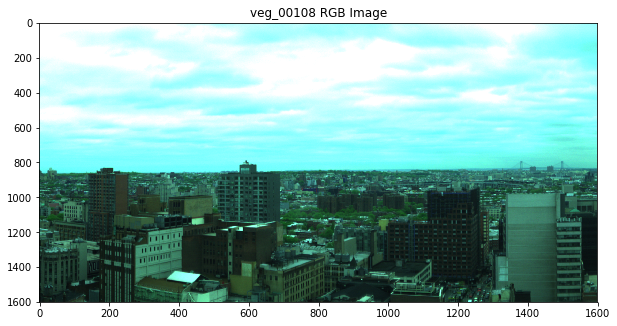

In [15]:
cube_norm = (cube_reshaped - cube_reshaped.min()) / (cube_reshaped.max() - cube_reshaped.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind = (np.abs(cube.waves - 650.0)).argmin()
green_ind = (np.abs(cube.waves - 550.0)).argmin()
blue_ind = (np.abs(cube.waves - 450.0)).argmin()

cube_reshaped2 = cube_norm.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
cube_scene = cube_reshaped2[:, :, [red_ind, green_ind, blue_ind]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00108 RGB Image')
ax.imshow(cube_scene, aspect=0.5)
plt.show()

In [16]:
cube_standard = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)
print(cube_standard.shape)

(2560000, 848)


#### Reading manually classified set for training and testing

In [17]:
sky_coords = read_labelled_coordinates("1_sky", "108")
clouds_coords = read_labelled_coordinates("2_clouds", "108")
veg_coords = read_labelled_coordinates("3_vegetation", "108")
wtr_coords = read_labelled_coordinates("4_water", "108")
blt_coords = read_labelled_coordinates("5_buildings", "108")
windows_coords = read_labelled_coordinates("6_windows", "108")
rds_coords = read_labelled_coordinates("7_roads", "108")
cars_coords = read_labelled_coordinates("8_cars", "108")
mtl_coords = read_labelled_coordinates("9_metal", "108")

1_sky: (300, 2)
2_clouds: (500, 2)
3_vegetation: (600, 2)
4_water: (50, 2)
5_buildings: (1020, 2)
6_windows: (500, 2)
7_roads: (30, 2)
8_cars: (100, 2)
9_metal: (100, 2)


In [18]:
# create position array and normalize

xy = coords(cube_sub.shape[1], cube_sub.shape[2])
xy = xy/xy.max()

#### split classified pixels into 80% training and 20% testing sets

In [19]:
trrat = 0.8
sky_train_ind, sky_test_ind = split_train_test_indices(sky_coords, 0, trrat, "sky")
clouds_train_ind, clouds_test_ind = split_train_test_indices(clouds_coords, 1, trrat, "clouds")
veg_train_ind, veg_test_ind = split_train_test_indices(veg_coords, 2, trrat, "veg")
wtr_train_ind, wtr_test_ind = split_train_test_indices(wtr_coords, 3, trrat, "wtr")
blt_train_ind, blt_test_ind = split_train_test_indices(blt_coords, 4, trrat, "blt")
windows_train_ind, windows_test_ind = split_train_test_indices(windows_coords, 5, trrat, "windows")
rds_train_ind, rds_test_ind = split_train_test_indices(rds_coords, 6, trrat, "rds")
cars_train_ind, cars_test_ind = split_train_test_indices(cars_coords, 7, trrat, "cars")
mtl_train_ind, mtl_test_ind = split_train_test_indices(mtl_coords, 8, trrat, "mtl")

sky: 240 60
clouds: 400 100
veg: 480 120
wtr: 40 10
blt: 816 204
windows: 400 100
rds: 24 6
cars: 80 20
mtl: 80 20


In [20]:
cube_std_3d = cube_standard.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
print(cube_std_3d.shape)
print(xy.shape)

(1600, 1600, 848)
(1600, 1600, 2)


In [21]:
cube_sky_train = cube_std_3d[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_std_3d[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
sky_xy_train = xy[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
sky_xy_test = xy[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print("sky ", cube_sky_train.shape, cube_sky_test.shape)

cube_clouds_train = cube_std_3d[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
cube_clouds_test = cube_std_3d[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
clouds_xy_train = xy[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
clouds_xy_test = xy[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
print("clouds ", cube_clouds_train.shape, cube_clouds_test.shape)

cube_veg_train = cube_std_3d[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_std_3d[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
veg_xy_train = xy[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
veg_xy_test = xy[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print("vegetation ", cube_veg_train.shape, cube_veg_test.shape)

cube_wtr_train = cube_std_3d[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
cube_wtr_test = cube_std_3d[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
wtr_xy_train = xy[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
wtr_xy_test = xy[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
print("water ", cube_wtr_train.shape, cube_wtr_test.shape)

cube_blt_train = cube_std_3d[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
cube_blt_test = cube_std_3d[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
blt_xy_train = xy[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
blt_xy_test = xy[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
print("built ", cube_blt_train.shape, cube_blt_test.shape)

cube_windows_train = cube_std_3d[windows_coords[windows_train_ind[:],0], windows_coords[windows_train_ind[:],1],:]
cube_windows_test = cube_std_3d[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
windows_xy_train = xy[windows_coords[windows_train_ind[:], 0], windows_coords[windows_train_ind[:], 1], :]
windows_xy_test = xy[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
print("windows ", cube_windows_train.shape, cube_windows_test.shape)

cube_rds_train = cube_std_3d[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
cube_rds_test = cube_std_3d[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
rds_xy_train = xy[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
rds_xy_test = xy[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
print("roads ", cube_rds_train.shape, cube_rds_test.shape)

cube_cars_train = cube_std_3d[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cube_cars_test = cube_std_3d[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
cars_xy_train = xy[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cars_xy_test = xy[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
print("cars ", cube_cars_train.shape, cube_cars_test.shape)

cube_mtl_train = cube_std_3d[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
cube_mtl_test = cube_std_3d[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
mtl_xy_train = xy[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
mtl_xy_test = xy[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
print("metal ", cube_mtl_train.shape, cube_mtl_test.shape)

sky  (240, 848) (60, 848)
clouds  (400, 848) (100, 848)
vegetation  (480, 848) (120, 848)
water  (40, 848) (10, 848)
built  (816, 848) (204, 848)
windows  (400, 848) (100, 848)
roads  (24, 848) (6, 848)
cars  (80, 848) (20, 848)
metal  (80, 848) (20, 848)


In [22]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_clouds_train, cube_veg_train, cube_wtr_train, cube_blt_train,
                            cube_windows_train, cube_rds_train, cube_cars_train, cube_mtl_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_clouds_train.shape[0] \
                    + [2]*cube_veg_train.shape[0] + [3]*cube_wtr_train.shape[0] \
                    + [4]*cube_blt_train.shape[0] + [5]*cube_windows_train.shape[0] \
                    + [6]*cube_rds_train.shape[0] + [7]*cube_cars_train.shape[0] + [8]*cube_mtl_train.shape[0]
xy_train = np.concatenate((sky_xy_train, clouds_xy_train, veg_xy_train, wtr_xy_train, blt_xy_train,
                             windows_xy_train, rds_xy_train, cars_xy_train, mtl_xy_train), axis=0)

cube_test = np.concatenate((cube_sky_test, cube_clouds_test, cube_veg_test, cube_wtr_test, cube_blt_test,
                            cube_windows_test, cube_rds_test, cube_cars_test, cube_mtl_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_clouds_test.shape[0] \
                    + [2]*cube_veg_test.shape[0] + [3]*cube_wtr_test.shape[0] \
                    + [4]*cube_blt_test.shape[0] + [5]*cube_windows_test.shape[0] \
                    + [6]*cube_rds_test.shape[0] + [7]*cube_cars_test.shape[0] + [8]*cube_mtl_test.shape[0]
xy_test = np.concatenate((sky_xy_test, clouds_xy_test, veg_xy_test, wtr_xy_test, blt_xy_test,
                             windows_xy_test, rds_xy_test, cars_xy_test, mtl_xy_test), axis=0)

In [23]:
cube_train_labels = np.array(cube_train_labels)
cube_test_labels = np.array(cube_test_labels)

print(cube_train.shape, cube_train_labels.shape, xy_train.shape)
print(cube_test.shape, cube_test_labels.shape, xy_test.shape)

(2560, 848) (2560,) (2560, 2)
(640, 848) (640,) (640, 2)


### Train CNN

In [85]:
filtersize = 200

cnn = CNN_Model(cube_std_3d.shape[2], filtersize)
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [86]:
#keras.utils.plot_model(cnn, show_shapes=True)
#cnn.summary()

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

In [87]:
CNNmodel = cnn.fit({"spectra":cube_train2, "spatial":xy_train}, cube_train_labels, 
                     validation_data=({"spectra":cube_test2, "spatial":xy_test}, cube_test_labels),
                     epochs=200, batch_size=512)

Epoch 1/200
5/5 [==============================] - 4s 778ms/step - loss: 2.0310 - accuracy: 0.3277 - val_loss: 1.2727 - val_accuracy: 0.6359
Epoch 2/200
5/5 [==============================] - 4s 713ms/step - loss: 1.1024 - accuracy: 0.6453 - val_loss: 0.8876 - val_accuracy: 0.6844
Epoch 3/200
5/5 [==============================] - 4s 773ms/step - loss: 0.8584 - accuracy: 0.7082 - val_loss: 0.7815 - val_accuracy: 0.7328
Epoch 4/200
5/5 [==============================] - 4s 811ms/step - loss: 0.7747 - accuracy: 0.7473 - val_loss: 0.6776 - val_accuracy: 0.7812
Epoch 5/200
5/5 [==============================] - 4s 730ms/step - loss: 0.6988 - accuracy: 0.7707 - val_loss: 0.6206 - val_accuracy: 0.7922
Epoch 6/200
5/5 [==============================] - 3s 697ms/step - loss: 0.6197 - accuracy: 0.7969 - val_loss: 0.5472 - val_accuracy: 0.8078
Epoch 7/200
5/5 [==============================] - 4s 744ms/step - loss: 0.5605 - accuracy: 0.8188 - val_loss: 0.4973 - val_accuracy: 0.8141
Epoch 8/200
5

Epoch 59/200
5/5 [==============================] - 4s 716ms/step - loss: 0.1513 - accuracy: 0.9488 - val_loss: 0.1785 - val_accuracy: 0.9422
Epoch 60/200
5/5 [==============================] - 4s 743ms/step - loss: 0.1646 - accuracy: 0.9434 - val_loss: 0.1934 - val_accuracy: 0.9234
Epoch 61/200
5/5 [==============================] - 3s 685ms/step - loss: 0.1807 - accuracy: 0.9379 - val_loss: 0.1731 - val_accuracy: 0.9375
Epoch 62/200
5/5 [==============================] - 4s 751ms/step - loss: 0.1586 - accuracy: 0.9414 - val_loss: 0.1810 - val_accuracy: 0.9422
Epoch 63/200
5/5 [==============================] - 4s 730ms/step - loss: 0.1642 - accuracy: 0.9422 - val_loss: 0.1805 - val_accuracy: 0.9391
Epoch 64/200
5/5 [==============================] - 3s 693ms/step - loss: 0.1688 - accuracy: 0.9418 - val_loss: 0.1688 - val_accuracy: 0.9391
Epoch 65/200
5/5 [==============================] - 4s 741ms/step - loss: 0.1678 - accuracy: 0.9453 - val_loss: 0.1925 - val_accuracy: 0.9344
Epoch 

5/5 [==============================] - 4s 712ms/step - loss: 0.0653 - accuracy: 0.9742 - val_loss: 0.1390 - val_accuracy: 0.9578
Epoch 174/200
5/5 [==============================] - 4s 720ms/step - loss: 0.0624 - accuracy: 0.9785 - val_loss: 0.1631 - val_accuracy: 0.9547
Epoch 175/200
5/5 [==============================] - 3s 677ms/step - loss: 0.0573 - accuracy: 0.9789 - val_loss: 0.1375 - val_accuracy: 0.9594
Epoch 176/200
5/5 [==============================] - 4s 703ms/step - loss: 0.0529 - accuracy: 0.9824 - val_loss: 0.1422 - val_accuracy: 0.9672
Epoch 177/200
5/5 [==============================] - 3s 682ms/step - loss: 0.0526 - accuracy: 0.9824 - val_loss: 0.1621 - val_accuracy: 0.9609
Epoch 178/200
5/5 [==============================] - 4s 734ms/step - loss: 0.0625 - accuracy: 0.9801 - val_loss: 0.1449 - val_accuracy: 0.9578
Epoch 179/200
5/5 [==============================] - 4s 757ms/step - loss: 0.0576 - accuracy: 0.9789 - val_loss: 0.1755 - val_accuracy: 0.9516
Epoch 180/200

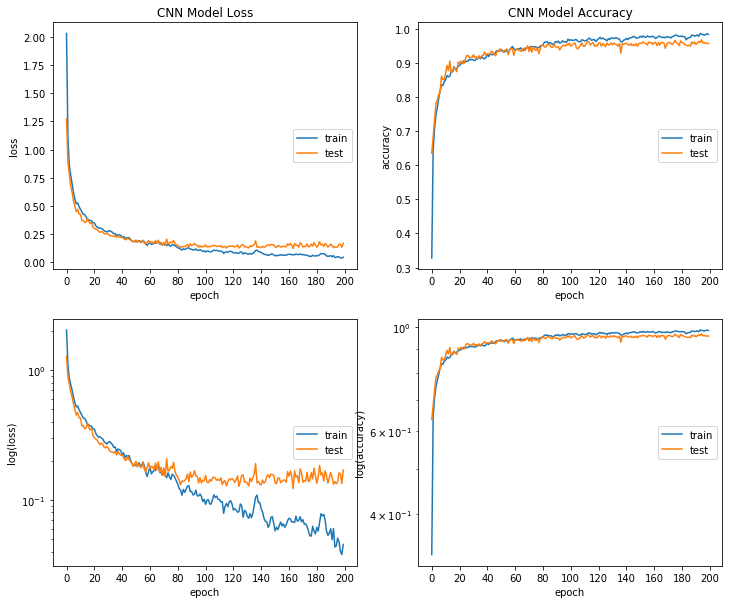

In [88]:
plot_loss_history(CNNmodel)

In [97]:
cnn = CNN_Model(cube_std_3d.shape[2], filtersize)
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodel = cnn.fit({"spectra":cube_train2, "spatial":xy_train}, cube_train_labels, 
                     validation_data=({"spectra":cube_test2, "spatial":xy_test}, cube_test_labels),
                     epochs=25, batch_size=512)

Epoch 1/25
5/5 [==============================] - 4s 730ms/step - loss: 2.4183 - accuracy: 0.3609 - val_loss: 1.5915 - val_accuracy: 0.5531
Epoch 2/25
5/5 [==============================] - 4s 720ms/step - loss: 1.2640 - accuracy: 0.6281 - val_loss: 0.9572 - val_accuracy: 0.7078
Epoch 3/25
5/5 [==============================] - 4s 727ms/step - loss: 0.9176 - accuracy: 0.6961 - val_loss: 0.8209 - val_accuracy: 0.7219
Epoch 4/25
5/5 [==============================] - 4s 703ms/step - loss: 0.7988 - accuracy: 0.7285 - val_loss: 0.6811 - val_accuracy: 0.8047
Epoch 5/25
5/5 [==============================] - 4s 824ms/step - loss: 0.6864 - accuracy: 0.7906 - val_loss: 0.6008 - val_accuracy: 0.8062
Epoch 6/25
5/5 [==============================] - 4s 706ms/step - loss: 0.6120 - accuracy: 0.7973 - val_loss: 0.5092 - val_accuracy: 0.8281
Epoch 7/25
5/5 [==============================] - 3s 675ms/step - loss: 0.5595 - accuracy: 0.8133 - val_loss: 0.4766 - val_accuracy: 0.8422
Epoch 8/25
5/5 [====

In [98]:
# model accuracy on training and testing sets

#train_loss, train_acc = cnn.evaluate({"spectra":cube_train2, "spatial":xy_train}, cube_train_labels)
#test_loss, test_acc = cnn.evaluate({"spectra":cube_test2, "spatial":xy_test}, cube_test_labels)

#print(train_acc, test_acc)

In [99]:
def get_acc(cnn, ctr, cte, xytr, xyte, lbtr, lbte):
    train_loss, train_acc = cnn.evaluate({"spectra":ctr, "spatial":xytr}, lbtr)
    test_loss, test_acc = cnn.evaluate({"spectra":cte, "spatial":xyte}, lbte)

    return train_acc, test_acc   

In [100]:
if filtersize==10:
    train_acc_10, test_acc_10 = get_acc(cnn, 
                                        cube_train2, cube_test2, 
                                        xy_train, xy_test, 
                                        cube_train_labels, cube_test_labels)
elif filtersize==20:
    train_acc_20, test_acc_20 = get_acc(cnn, 
                                        cube_train2, cube_test2, 
                                        xy_train, xy_test, 
                                        cube_train_labels, cube_test_labels)
elif filtersize==100:
    train_acc_100, test_acc_100 = get_acc(cnn, 
                                        cube_train2, cube_test2, 
                                        xy_train, xy_test, 
                                        cube_train_labels, cube_test_labels)
elif filtersize==200:
    train_acc_200, test_acc_200 = get_acc(cnn, 
                                        cube_train2, cube_test2, 
                                        xy_train, xy_test, 
                                        cube_train_labels, cube_test_labels)

20/20 [==============================] - 0s 10ms/step - loss: 0.2652 - accuracy: 0.9156


### Predict pixel classification on veg_00108

In [101]:
cube_standard_1 = cube_standard.reshape(cube_standard.shape[0], cube_standard.shape[1], 1)
print(cube_standard_1.shape)
xy_2d = xy.reshape((xy.shape[0] * xy.shape[1]), xy.shape[2])
print(xy_2d.shape)

(2560000, 848, 1)
(2560000, 2)


In [102]:
# classify entire binned cube
import time
start_time = time.time()

probCube = cnn.predict({"spectra":cube_standard_1, "spatial":xy_2d})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:11:44


In [103]:
predictCube = probCube.argmax(axis=-1)

In [104]:
predictCube_reshape = predictCube.reshape(cube_sub.shape[1], cube_sub.shape[2])

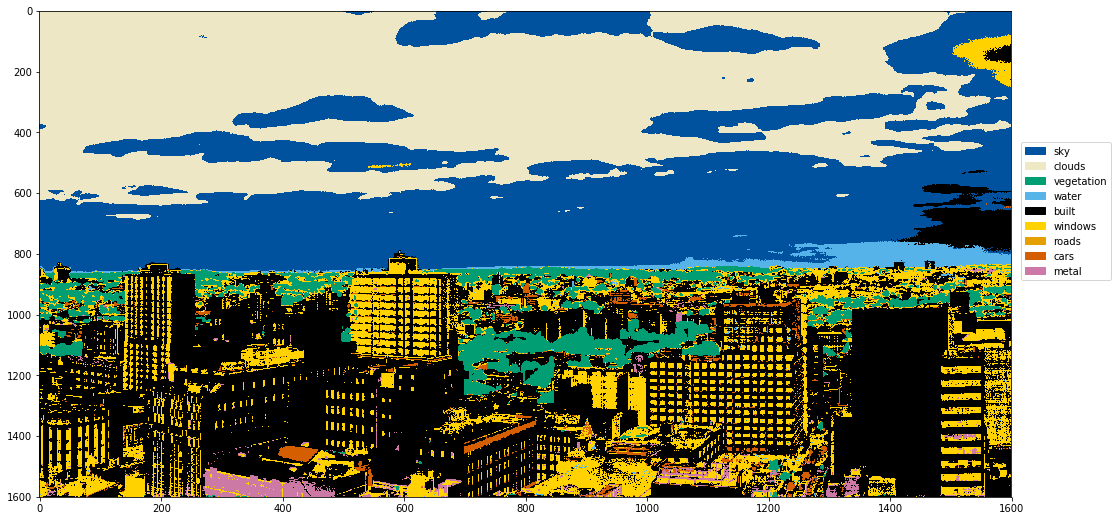

In [105]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_1_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

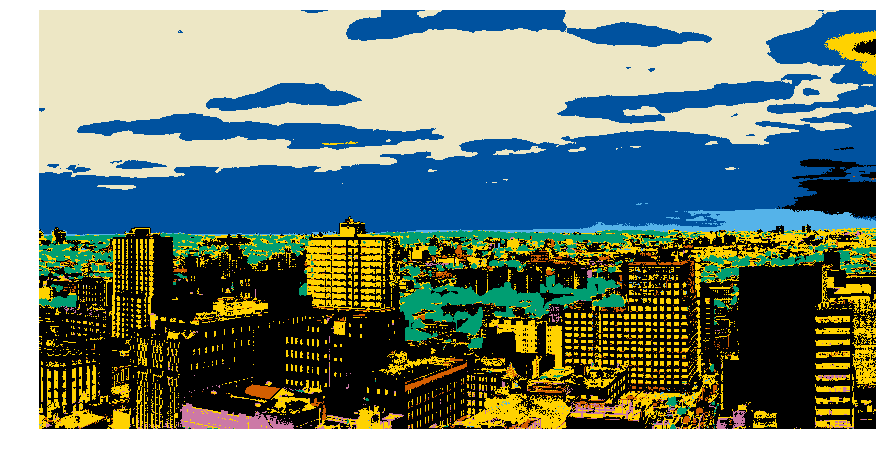

In [106]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_filter_size_{0}_predict_map.png".format(filtersize), bbox_inches='tight')

In [107]:
import pickle
pickle.dump(predictCube_reshape, open("./plots/CNN_filter_size_{0}_predict_map.png.pickle".format(filtersize), "wb"))

### Evaluation Metrics (veg_00108)

In [108]:
labels_pred_sky = predictCube_reshape[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:],1]]
labels_pred_veg = predictCube_reshape[veg_coords[veg_test_ind[:],0], veg_coords[veg_test_ind[:],1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[wtr_test_ind[:],0], wtr_coords[wtr_test_ind[:],1]]
labels_pred_blt = predictCube_reshape[blt_coords[blt_test_ind[:],0], blt_coords[blt_test_ind[:],1]]
labels_pred_windows = predictCube_reshape[windows_coords[windows_test_ind[:],0], windows_coords[windows_test_ind[:],1]]
labels_pred_rds = predictCube_reshape[rds_coords[rds_test_ind[:],0], rds_coords[rds_test_ind[:],1]]
labels_pred_cars = predictCube_reshape[cars_coords[cars_test_ind[:],0], cars_coords[cars_test_ind[:],1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[mtl_test_ind[:],0], mtl_coords[mtl_test_ind[:],1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [109]:
labels_true_sky = np.full(len(sky_test_ind), 0)
labels_true_clouds = np.full(len(clouds_test_ind), 1)
labels_true_veg = np.full(len(veg_test_ind), 2)
labels_true_wtr = np.full(len(wtr_test_ind), 3)
labels_true_blt = np.full(len(blt_test_ind), 4)
labels_true_windows = np.full(len(windows_test_ind), 5)
labels_true_rds = np.full(len(rds_test_ind), 6)
labels_true_cars = np.full(len(cars_test_ind), 7)
labels_true_mtl = np.full(len(mtl_test_ind), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [110]:
print(labels_pred.shape)
print(labels_true.shape)

(640,)
(640,)


In [111]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[ 59   1   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0]
 [  0   0 118   0   2   0   0   0   0]
 [  0   0   0  10   0   0   0   0   0]
 [  0   0   0   0 193   6   0   2   3]
 [  0   0   0   0   8  90   0   2   0]
 [  0   0   0   0   6   0   0   0   0]
 [  0   0   0   0   7   5   0   7   1]
 [  0   0   0   0   7   4   0   0   9]]

Accuracy Score
0.915625

Classification Report
             precision    recall  f1-score   support

        sky       1.00      0.98      0.99        60
     clouds       0.99      1.00      1.00       100
 vegetation       1.00      0.98      0.99       120
      water       1.00      1.00      1.00        10
      built       0.87      0.95      0.90       204
    windows       0.86      0.90      0.88       100
      roads       0.00      0.00      0.00         6
       cars       0.64      0.35      0.45        20
      metal       0.69      0.45      0.55        20

avg / total       0.90      0.92      0.91       64

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [112]:
f = open("./metrics/CNN_filter_size_{0}_metrics.txt".format(filtersize), "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---

## Plot Results

In [113]:
import numpy as np

#train_acc = [train_acc_200, train_acc_100, train_acc_50, train_acc_20, train_acc_10, train_acc_5]
#test_acc =[test_acc_100, test_acc_100, test_acc_50, test_acc_20, test_acc_10, test_acc_5]

train_acc = [train_acc_200, train_acc_100, 0.9574, train_acc_20, train_acc_10, 0.9062]
test_acc =[test_acc_200, test_acc_100, 0.9422, test_acc_20, test_acc_10, 0.8984]

print(train_acc)
print(test_acc)

[0.9195312261581421, 0.9117187261581421, 0.9574, 0.935546875, 0.9468749761581421, 0.9062]
[0.921875, 0.921875, 0.9422, 0.9234374761581421, 0.9203125238418579, 0.8984]


In [17]:
import numpy as np

train_acc = [0.9195312261581421, 0.9217187261581421, 0.9574, 0.935546875, 0.9368749761581421, 0.9062]
test_acc = [0.9156, 0.921875, 0.9422, 0.9234374761581421, 0.9203125238418579, 0.8984]

print(train_acc)
print(test_acc)

[0.9195312261581421, 0.9217187261581421, 0.9574, 0.935546875, 0.9368749761581421, 0.9062]
[0.9156, 0.921875, 0.9422, 0.9234374761581421, 0.9203125238418579, 0.8984]


In [18]:
n_groups = 6

avg_prec = np.zeros(n_groups)
avg_recall = np.zeros(n_groups)
avg_f1 = np.zeros(n_groups)

In [19]:
def read_prec_recall(file, line):
    Nums = []
    for num in file[line].split():
        try:
            Nums.append(float(num))
        except ValueError:
            pass
    prec = Nums[0]
    recall = Nums[1]
    f1 = Nums[2]
    
    return prec, recall, f1

In [20]:
filter_size = [200, 100, 50, 20, 10, 5]

i=0
for size in filter_size:
    if size in [200, 100, 20, 10]:
        filename = "./metrics/CNN_filter_size_{0}_metrics.txt".format(size)
        f = open(filename, "r")
        f1 = f.readlines()
        avg_prec[i], avg_recall[i], avg_f1[i] = read_prec_recall(f1, 27)
        f.close()
    i += 1

In [21]:
filename = "./metrics/CNN_Model2_spatial_train_108_test_108_metrics.txt"
f = open(filename, "r")
f1 = f.readlines()
i=2
avg_prec[i], avg_recall[i], avg_f1[i] = read_prec_recall(f1, 27)
f.close()

In [22]:
filename = "./metrics/CNN_Model1_spatial_train_108_test_108_metrics.txt"
f = open(filename, "r")
f1 = f.readlines()
i=5
avg_prec[i], avg_recall[i], avg_f1[i] = read_prec_recall(f1, 27)
f.close()

In [23]:
print(avg_prec)
print(avg_recall)
print(avg_f1)

[0.9  0.91 0.97 0.91 0.91 0.9 ]
[0.92 0.92 0.97 0.92 0.92 0.91]
[0.91 0.91 0.97 0.91 0.91 0.89]


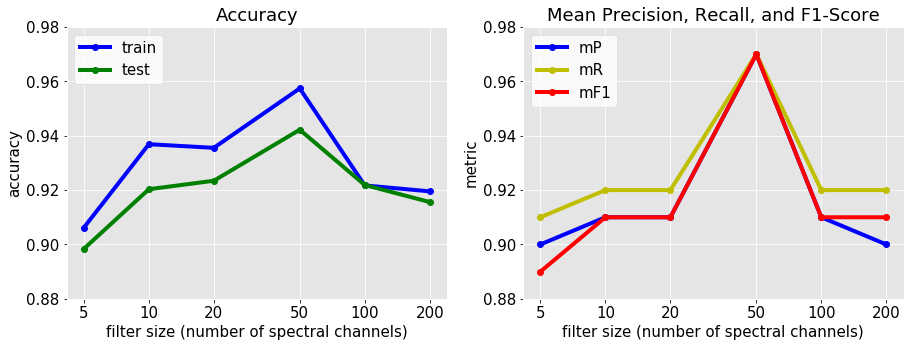

In [26]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 15
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(filter_size, train_acc, '-o', color='b', lw=4, label='train')
ax1.plot(filter_size, test_acc, '-o', color='g', lw=4, label='test')
ax1.set_title("Accuracy", fontsize=18)
ax1.set_xlabel("filter size (number of spectral channels)")
ax1.set_ylabel("accuracy")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, facecolor='white', loc='upper left')
ax1.set_xscale('log', basex=2)
ax1.xaxis.set_major_formatter(ScalarFormatter())
ax1.set_xticks(filter_size)
ax1.set_ylim(0.88,0.98)

ax2.plot(filter_size, avg_prec, '-o', color='b', lw=4, label='mP')
ax2.plot(filter_size, avg_recall, '-o', color='y', lw=4, label='mR')
ax2.plot(filter_size, avg_f1, '-o', color='r', lw=4, label='mF1')
ax2.set_title("Mean Precision, Recall, and F1-Score", fontsize=18)
ax2.set_xlabel("filter size (number of spectral channels)")
ax2.set_ylabel("metric")
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, facecolor='white', loc='upper left')
ax2.set_xscale('log', basex=2)
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.set_xticks(filter_size)
ax2.set_ylim(0.88,0.98)

plt.show()
fig.savefig("./plots/CNN_spatial_train_108_filter_sizes_metrics.png", bbox_inches='tight', dpi=300)